In [1]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from okcupid_stackoverflow.utils.evaluate_model.evaluate_model import run_evaluate_model

In [2]:
def _create_train_validation_set(df):

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_x = train_df["cleaned_body"]
    train_y = train_df["label"]

    val_x = val_df["cleaned_body"]
    val_y = val_df["label"]

    return train_x, train_y, val_x, val_y

def fit_tf_idf_vector(df):

    train_x, train_y, val_x, val_y = _create_train_validation_set(df)

    vectorizer = TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 4),
        max_features=10000,
    )

    vectorizer.fit(train_x)
    x_train = vectorizer.transform(train_x)
    x_val = vectorizer.transform(val_x)

    return x_train, train_y, x_val, val_y


def fit_logistic_reg_on_tf_idf(x_train, y_train, save_external=False):

    clf = LogisticRegression(solver="lbfgs")
    clf.fit(x_train, y_train)

    if save_external:
        joblib.dump(clf, "tf_idf_logistic.pkl")

    return clf


def evaluate_logistic_reg_on_tf_idf(clf, x_val, y_val):
    df = pd.DataFrame()
    df["label"] = y_val
    df["pred_prob"] = clf.predict_proba(x_val)[:, 1]
    df["pred"] = np.where(df["pred_prob"] >= 0.5, 1, 0)

    run_evaluate_model(df)

In [3]:
df = pd.read_parquet("../data/processed/cleaned.parquet")

In [4]:
x_train, train_y, x_val, val_y = fit_tf_idf_vector(df)

In [6]:
clf = fit_logistic_reg_on_tf_idf(x_train, train_y, save_external=False)

Model Performance metrics:
------------------------------
Log Loss: 0.0 4
Accuracy: 0.7802
Precision: 0.7808
Recall: 0.7802
F1 Score: 0.7801

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.79      0.76      0.78     10071
           0       0.77      0.80      0.78      9929

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       7648  2423
        0       1974  7955


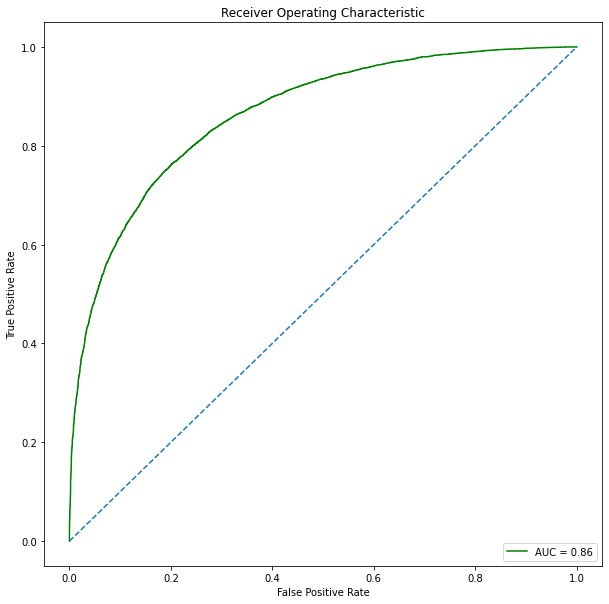

In [8]:
evaluate_logistic_reg_on_tf_idf(clf, x_val, val_y)